# Описание проекта

Предоставлены данные с параметрами добычи и отчистки золотосодержащей руды. Необходимо построить модель машинного обучения, предсказывающую коэффициент восстановления золота, из золотосодержащей руды.

# Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import trange
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:,.2f}'.format

## Изучение файлов

In [2]:
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv' , index_col='date')
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv', index_col='date')
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv', index_col='date')

In [3]:
def review(df):
    display('Размер таблицы')
    display(df.shape)
    print()
    display('Общая информащия')
    display(df.info())
    print()
    display('Описательная статистика')
    display(df.describe())
    print()
    display('Процент пропусков в признаках')
    display(df.isnull().sum().sort_values(ascending=False) / df.shape[0] * 100)
    print()
    display('Корреляционная матрица')
    sns.set(rc={'figure.figsize':(40, 40)})
    sns.heatmap(df.corr())
    plt.show()
    display('-' * 100)

'Размер таблицы'

(16860, 86)

'Общая информащия'

<class 'pandas.core.frame.DataFrame'>
Index: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant                      15598 non-null float64
primary_cleaner.i

None

'Описательная статистика'

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,"16,788.00","16,788.00","16,490.00","16,789.00","15,339.00","16,794.00","16,677.00","16,715.00","16,794.00","15,553.00","15,598.00","16,860.00","15,875.00","16,778.00","16,502.00","16,224.00","16,778.00","16,777.00","16,761.00","16,579.00","16,777.00","16,820.00","16,827.00","16,820.00","16,833.00","16,822.00","16,833.00","16,821.00","16,833.00","16,833.00","16,833.00","16,833.00","15,618.00","16,778.00","16,632.00","16,347.00","16,443.00","16,568.00","16,777.00","15,816.00","16,514.00","16,237.00","14,956.00","16,778.00","16,778.00","16,698.00","16,778.00","14,287.00","14,610.00","16,778.00","14,611.00","14,611.00","16,807.00","16,807.00","16,807.00","16,807.00","16,807.00","16,814.00","16,802.00","16,809.00","16,257.00","16,809.00","16,802.00","16,802.00","16,776.00","16,764.00","14,874.00","16,778.00","16,497.00","16,751.00","16,705.00","16,748.00","16,763.00","16,747.00","16,752.00","16,750.00","16,731.00","16,747.00","16,768.00","16,767.00","16,775.00","16,775.00","16,775.00","16,776.00","16,757.00","16,775.00"
mean,4.72,9.11,8.30,39.47,67.21,8.76,2.

'Процент пропусков в признаках'

rougher.output.recovery                              15.26
rougher.output.tail_ag                               13.35
rougher.output.tail_sol                              13.34
rougher.output.tail_au                               13.34
secondary_cleaner.output.tail_sol                    11.78
rougher.input.floatbank11_xanthate                   11.29
final.output.recovery                                 9.02
primary_cleaner.input.sulfate                         7.75
primary_cleaner.input.depressant                      7.49
rougher.calculation.au_pb_ratio                       7.37
rougher.input.floatbank10_sulfate                     6.19
primary_cleaner.input.xanthate                        5.84
primary_cleaner.output.concentrate_sol                3.77
rougher.input.floatbank11_sulfate                     3.70
rougher.state.floatbank10_e_air                       3.58
rougher.input.feed_rate                               3.04
rougher.input.feed_size                               2.

'Корреляционная матрица'

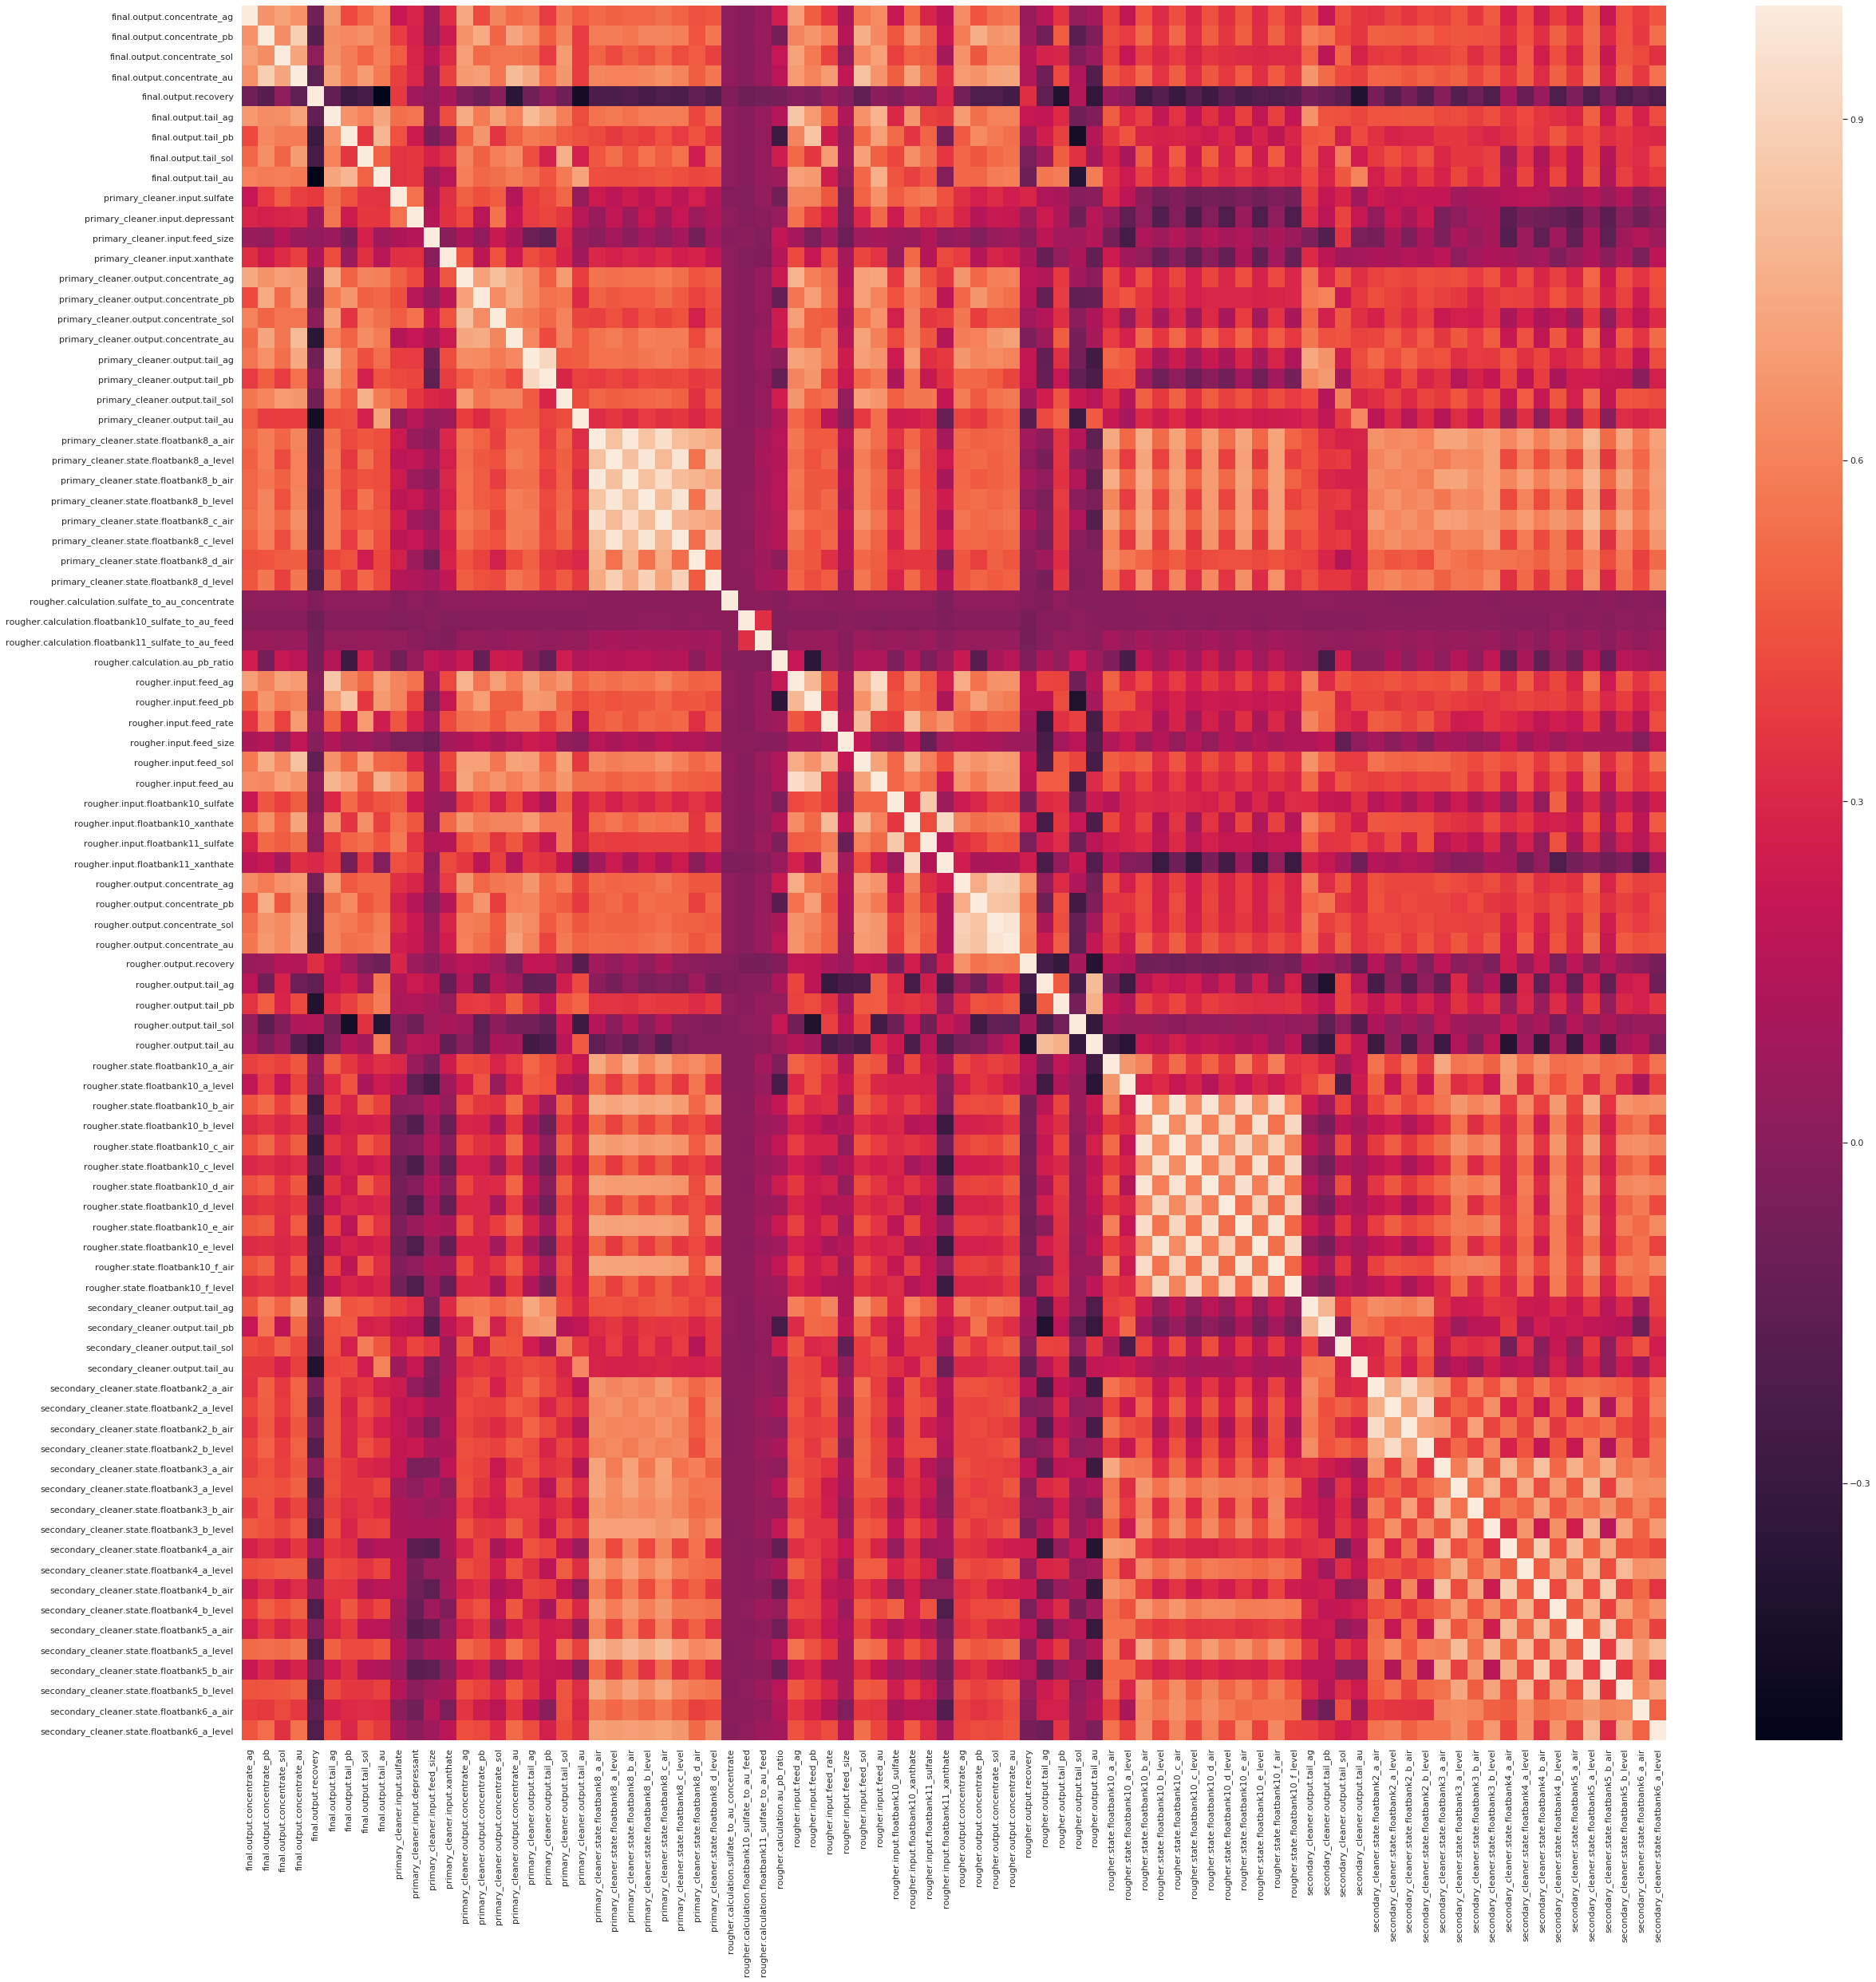

'----------------------------------------------------------------------------------------------------'

'Размер таблицы'

(5856, 52)

'Общая информащия'

<class 'pandas.core.frame.DataFrame'>
Index: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.input.feed_ag                         584

None

'Описательная статистика'

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,"5,554.00","5,572.00","5,856.00","5,690.00","5,840.00","5,840.00","5,840.00","5,840.00","5,840.00","5,840.00","5,840.00","5,840.00","5,840.00","5,840.00","5,816.00","5,834.00","5,789.00","5,840.00","5,599.00","5,733.00","5,801.00","5,503.00","5,839.00","5,840.00","5,839.00","5,840.00","5,839.00","5,840.00","5,839.00","5,840.00","5,839.00","5,840.00","5,839.00","5,840.00","5,836.00","5,840.00","5,833.00","5,840.00","5,822.00","5,840.00","5,840.00","5,840.00","5,840.00","5,840.00","5,840.00","5,840.00","5,840.00","5,840.00","5,840.00","5,840.00","5,840.00","5,840.00"
mean,170.52,8.48,7.26,1.32,"1,481.99",-509.06,"1,486.91",-511.74,"1,468.50",-509.74,"1,486.40",-510.72,8.74,3.55,458.49,55.94,35.11,8.70,13.44,6.17,13.06,6.42,"1,016.29",-404.98,"1,270.60",-482.15,"1,253.50",-480.95,"1,169.68",-482.15,"1,018.39",-476.55,962.01,-477.80,25.48,-513.71,21.08,-512.33,24.35,-519.42,20.07,-515.03,15.64,-516.27,13.15,-476.34,12.31,-512.21,9.47,-505.02,16.68,-512.35
std,49.61,3.35,0.61,0.69,310.45,61.34,313.22,67.14,309.98,62.67,313.73,65.42,2.99,1.33,155.96,22.72,10.79,2.80,4.00,1.67,4.53,1.12,226.49,100.95,285.25,55.40,290.70,53.76,285.41,54.97,231.68,67.00,220.86,68.34,5.45,62.45,5.94,63.38,7.95,73.97,7.64,60.46,4.66,62.76,4.30,105.55,3.76,58.86,3.31,68.79,5.40,69.92
min,0.00,0.00,5.65,0.00,0.00,-799.77,0.00,-800.03,0.00,-800.00,0.00,-799.84,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00,-0.12,-657.95,-0.82,-650.35,-0.28,-650.00,-1.05,-648.39,-2.08,-650.15,-2.59,-650.03,0.00,-799.61,0.00,-798.47,0.00,-799.76,0.00,-809.33,0.00,-799.80,0.00,-800.84,-0.22,-799.66,0.53,-800.22,-0.08,-809.86
25%,143.34,6.41,6.89,0.89,"1,497.19",-500.46,"1,497.15",-500.94,"1,437.05",-501.30,"1,498.41",-500.55,7.60,3.08,399.78,43.89,33.38,7.76,11.01,5.88,11.00,5.99,998.97,-499.97,"1,199.50",-500.33,"1,195.46",-500.31,"1,004.58",-500.58,998.87,-500.27,900.52,-500.77,24.91,-500.24,19.96,-500.25,22.03,-500.37,15.98,-500.17,12.06,-501.05,11.88,-500.42,10.12,-500.88,7.99,-500.22,13.01,-500.83
50%,176.10,8.02,7.26,1.18,"1,554.66",-500.00,"1,553.27",-500.07,"1,546.16",-500.08,"1,552.09",-500.05,9.63,3.68,489.53,50.00,37.34

'Процент пропусков в признаках'

rougher.input.floatbank11_xanthate           6.03
primary_cleaner.input.sulfate                5.16
primary_cleaner.input.depressant             4.85
rougher.input.floatbank10_sulfate            4.39
primary_cleaner.input.xanthate               2.83
rougher.input.floatbank10_xanthate           2.10
rougher.input.feed_sol                       1.14
rougher.input.floatbank11_sulfate            0.94
rougher.input.feed_rate                      0.68
secondary_cleaner.state.floatbank3_a_air     0.58
secondary_cleaner.state.floatbank2_b_air     0.39
rougher.input.feed_size                      0.38
secondary_cleaner.state.floatbank2_a_air     0.34
rougher.state.floatbank10_a_air              0.29
rougher.state.floatbank10_d_air              0.29
rougher.state.floatbank10_b_air              0.29
rougher.state.floatbank10_c_air              0.29
rougher.state.floatbank10_f_air              0.29
rougher.state.floatbank10_e_air              0.29
primary_cleaner.state.floatbank8_a_air       0.27


'Корреляционная матрица'

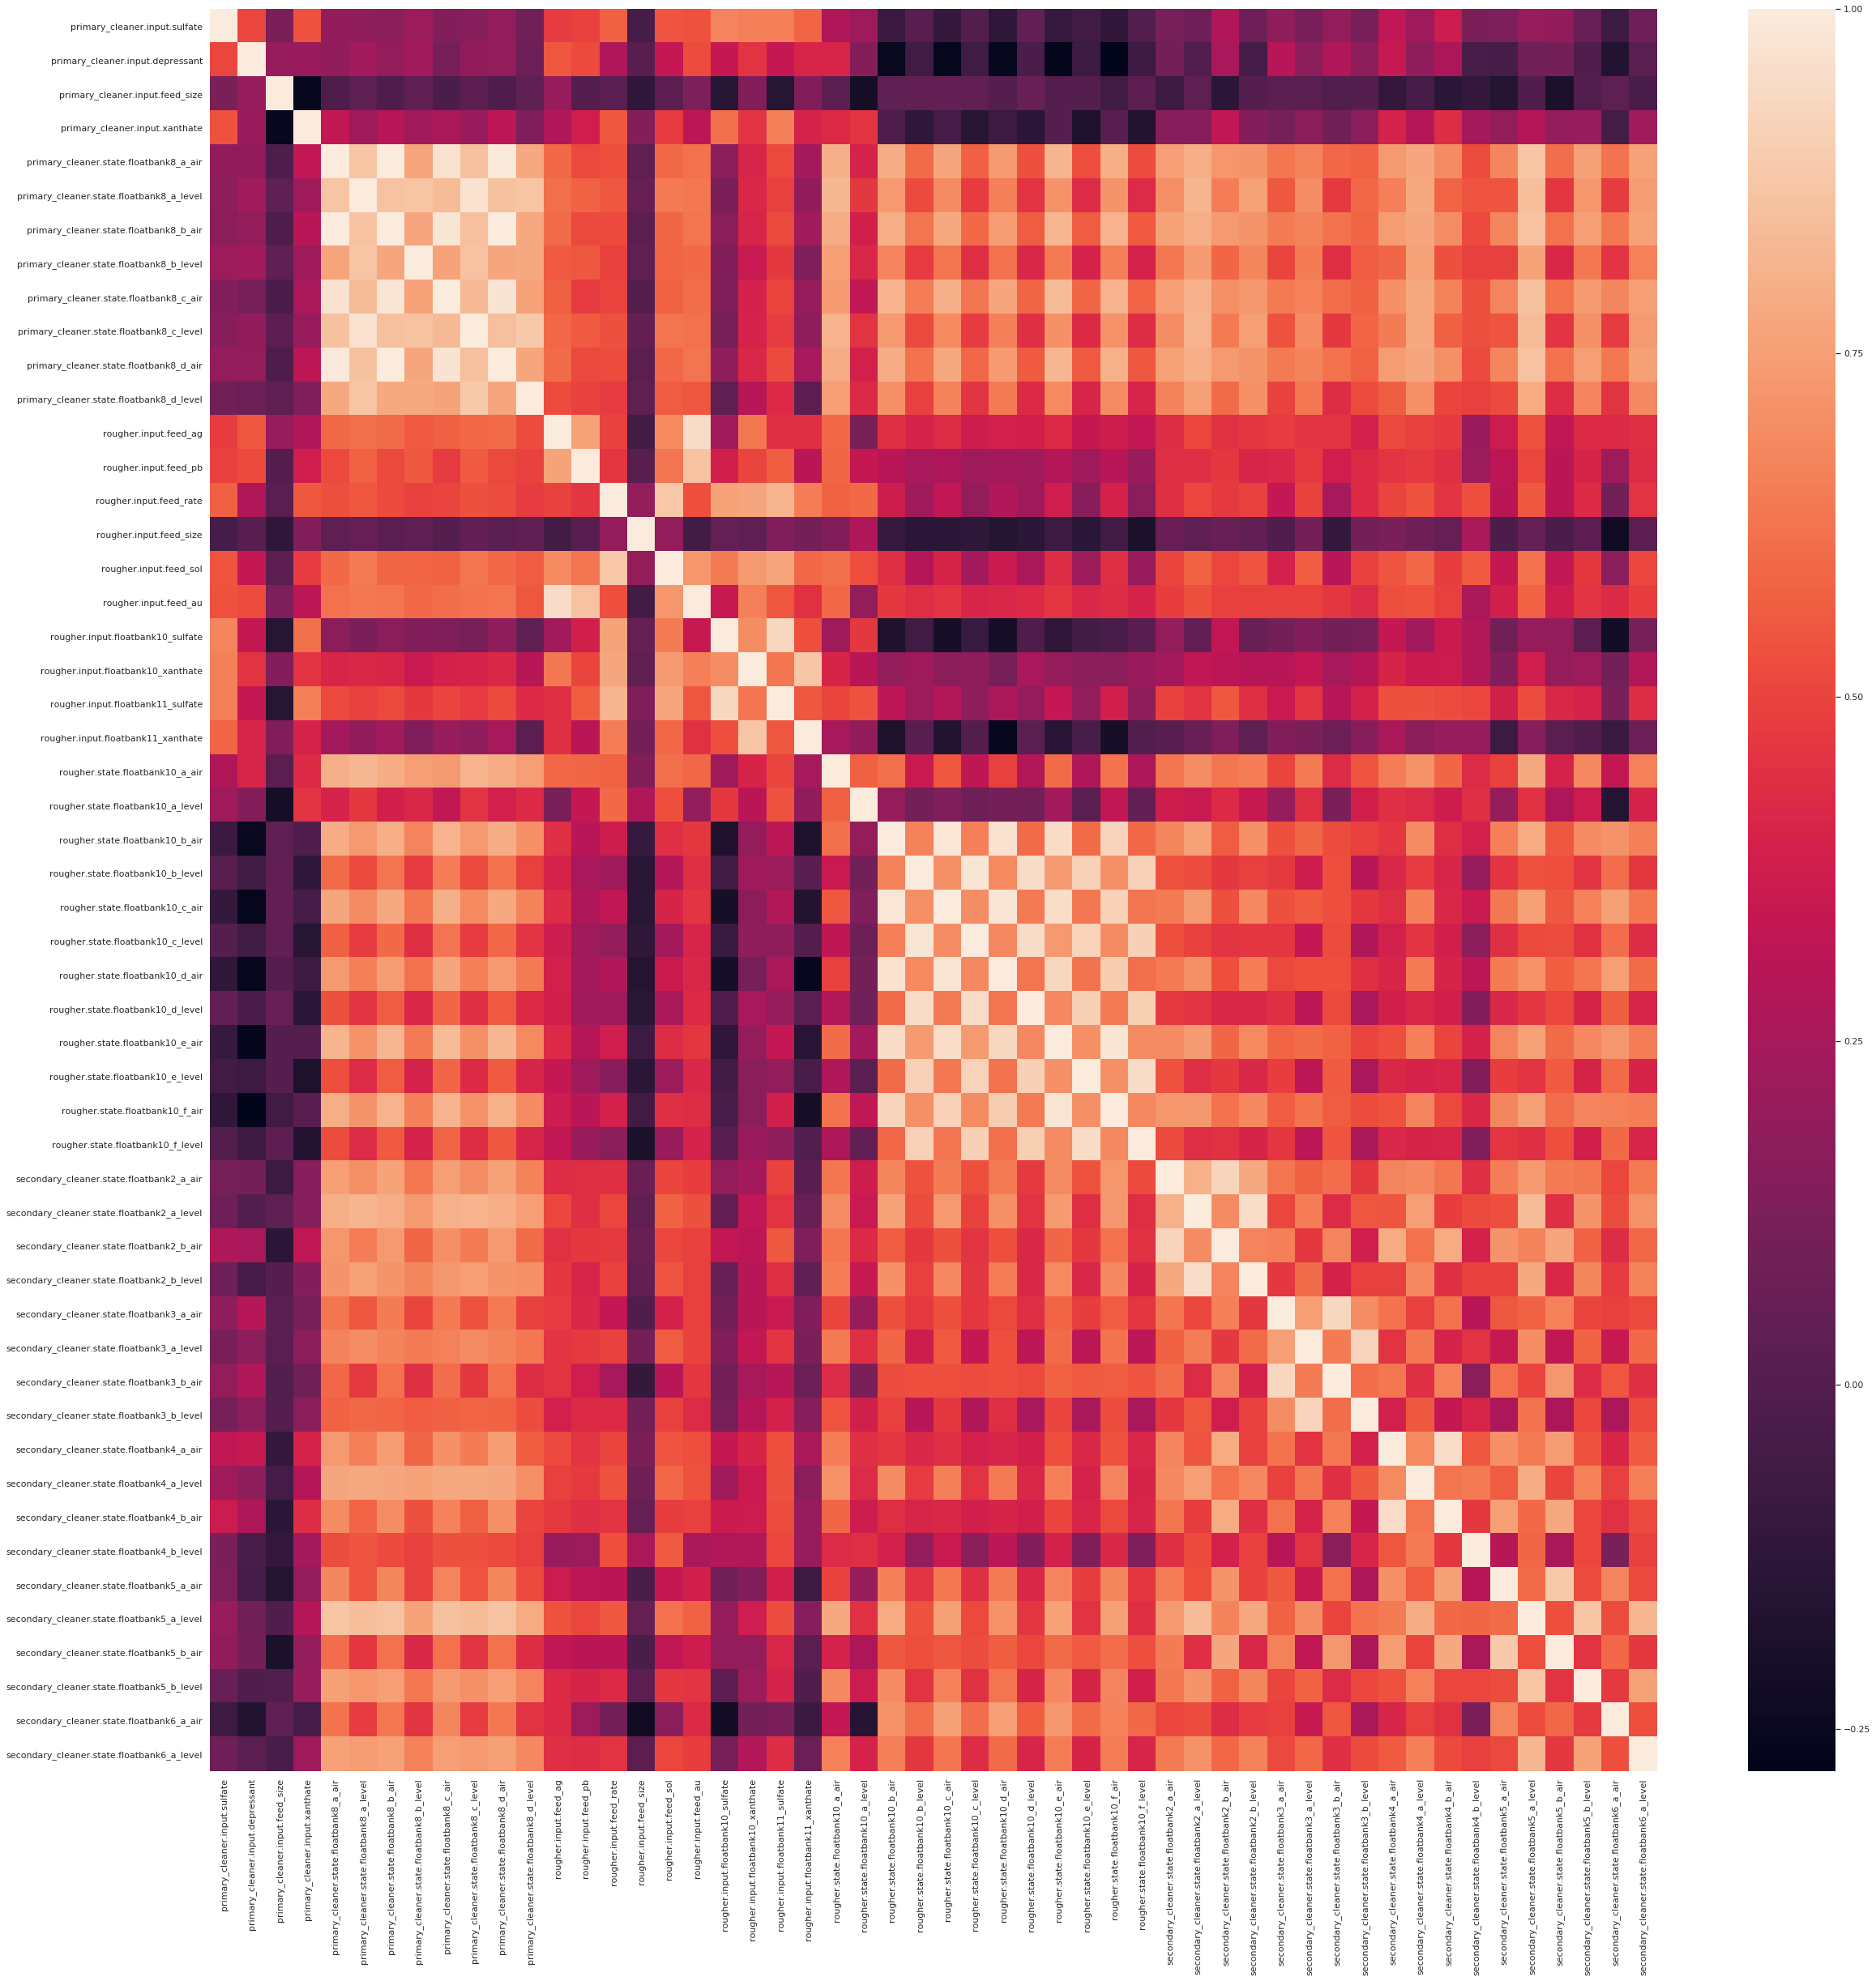

'----------------------------------------------------------------------------------------------------'

'Размер таблицы'

(22716, 86)

'Общая информащия'

<class 'pandas.core.frame.DataFrame'>
Index: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant                      21170 non-null float64
primary_cleaner.i

None

'Описательная статистика'

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,"22,627.00","22,629.00","22,331.00","22,630.00","20,753.00","22,633.00","22,516.00","22,445.00","22,635.00","21,107.00","21,170.00","22,716.00","21,565.00","22,618.00","22,268.00","21,918.00","22,618.00","22,614.00","22,594.00","22,365.00","22,617.00","22,660.00","22,667.00","22,660.00","22,673.00","22,662.00","22,673.00","22,661.00","22,673.00","22,672.00","22,672.00","22,672.00","21,089.00","22,618.00","22,472.00","22,163.00","22,277.00","22,357.00","22,617.00","21,415.00","22,247.00","22,038.00","20,459.00","22,618.00","22,618.00","22,526.00","22,618.00","19,597.00","19,979.00","22,618.00","19,980.00","19,980.00","22,646.00","22,647.00","22,646.00","22,647.00","22,646.00","22,654.00","22,641.00","22,649.00","22,096.00","22,649.00","22,641.00","22,642.00","22,616.00","22,600.00","20,501.00","22,618.00","22,333.00","22,591.00","22,538.00","22,588.00","22,585.00","22,587.00","22,592.00","22,590.00","22,571.00","22,587.00","22,608.00","22,607.00","22,615.00","22,615.00","22,615.00","22,616.00","22,597.00","22,615.00"
mean,4.78,9.10,8.64,40.00,67.45,8.92,2.

'Процент пропусков в признаках'

rougher.output.recovery                              13.73
rougher.output.tail_ag                               12.05
rougher.output.tail_sol                              12.04
rougher.output.tail_au                               12.04
rougher.input.floatbank11_xanthate                    9.94
secondary_cleaner.output.tail_sol                     9.75
final.output.recovery                                 8.64
rougher.calculation.au_pb_ratio                       7.16
primary_cleaner.input.sulfate                         7.08
primary_cleaner.input.depressant                      6.81
rougher.input.floatbank10_sulfate                     5.73
primary_cleaner.input.xanthate                        5.07
primary_cleaner.output.concentrate_sol                3.51
rougher.input.floatbank11_sulfate                     2.98
rougher.state.floatbank10_e_air                       2.73
rougher.input.feed_rate                               2.43
rougher.input.floatbank10_xanthate                    2.

'Корреляционная матрица'

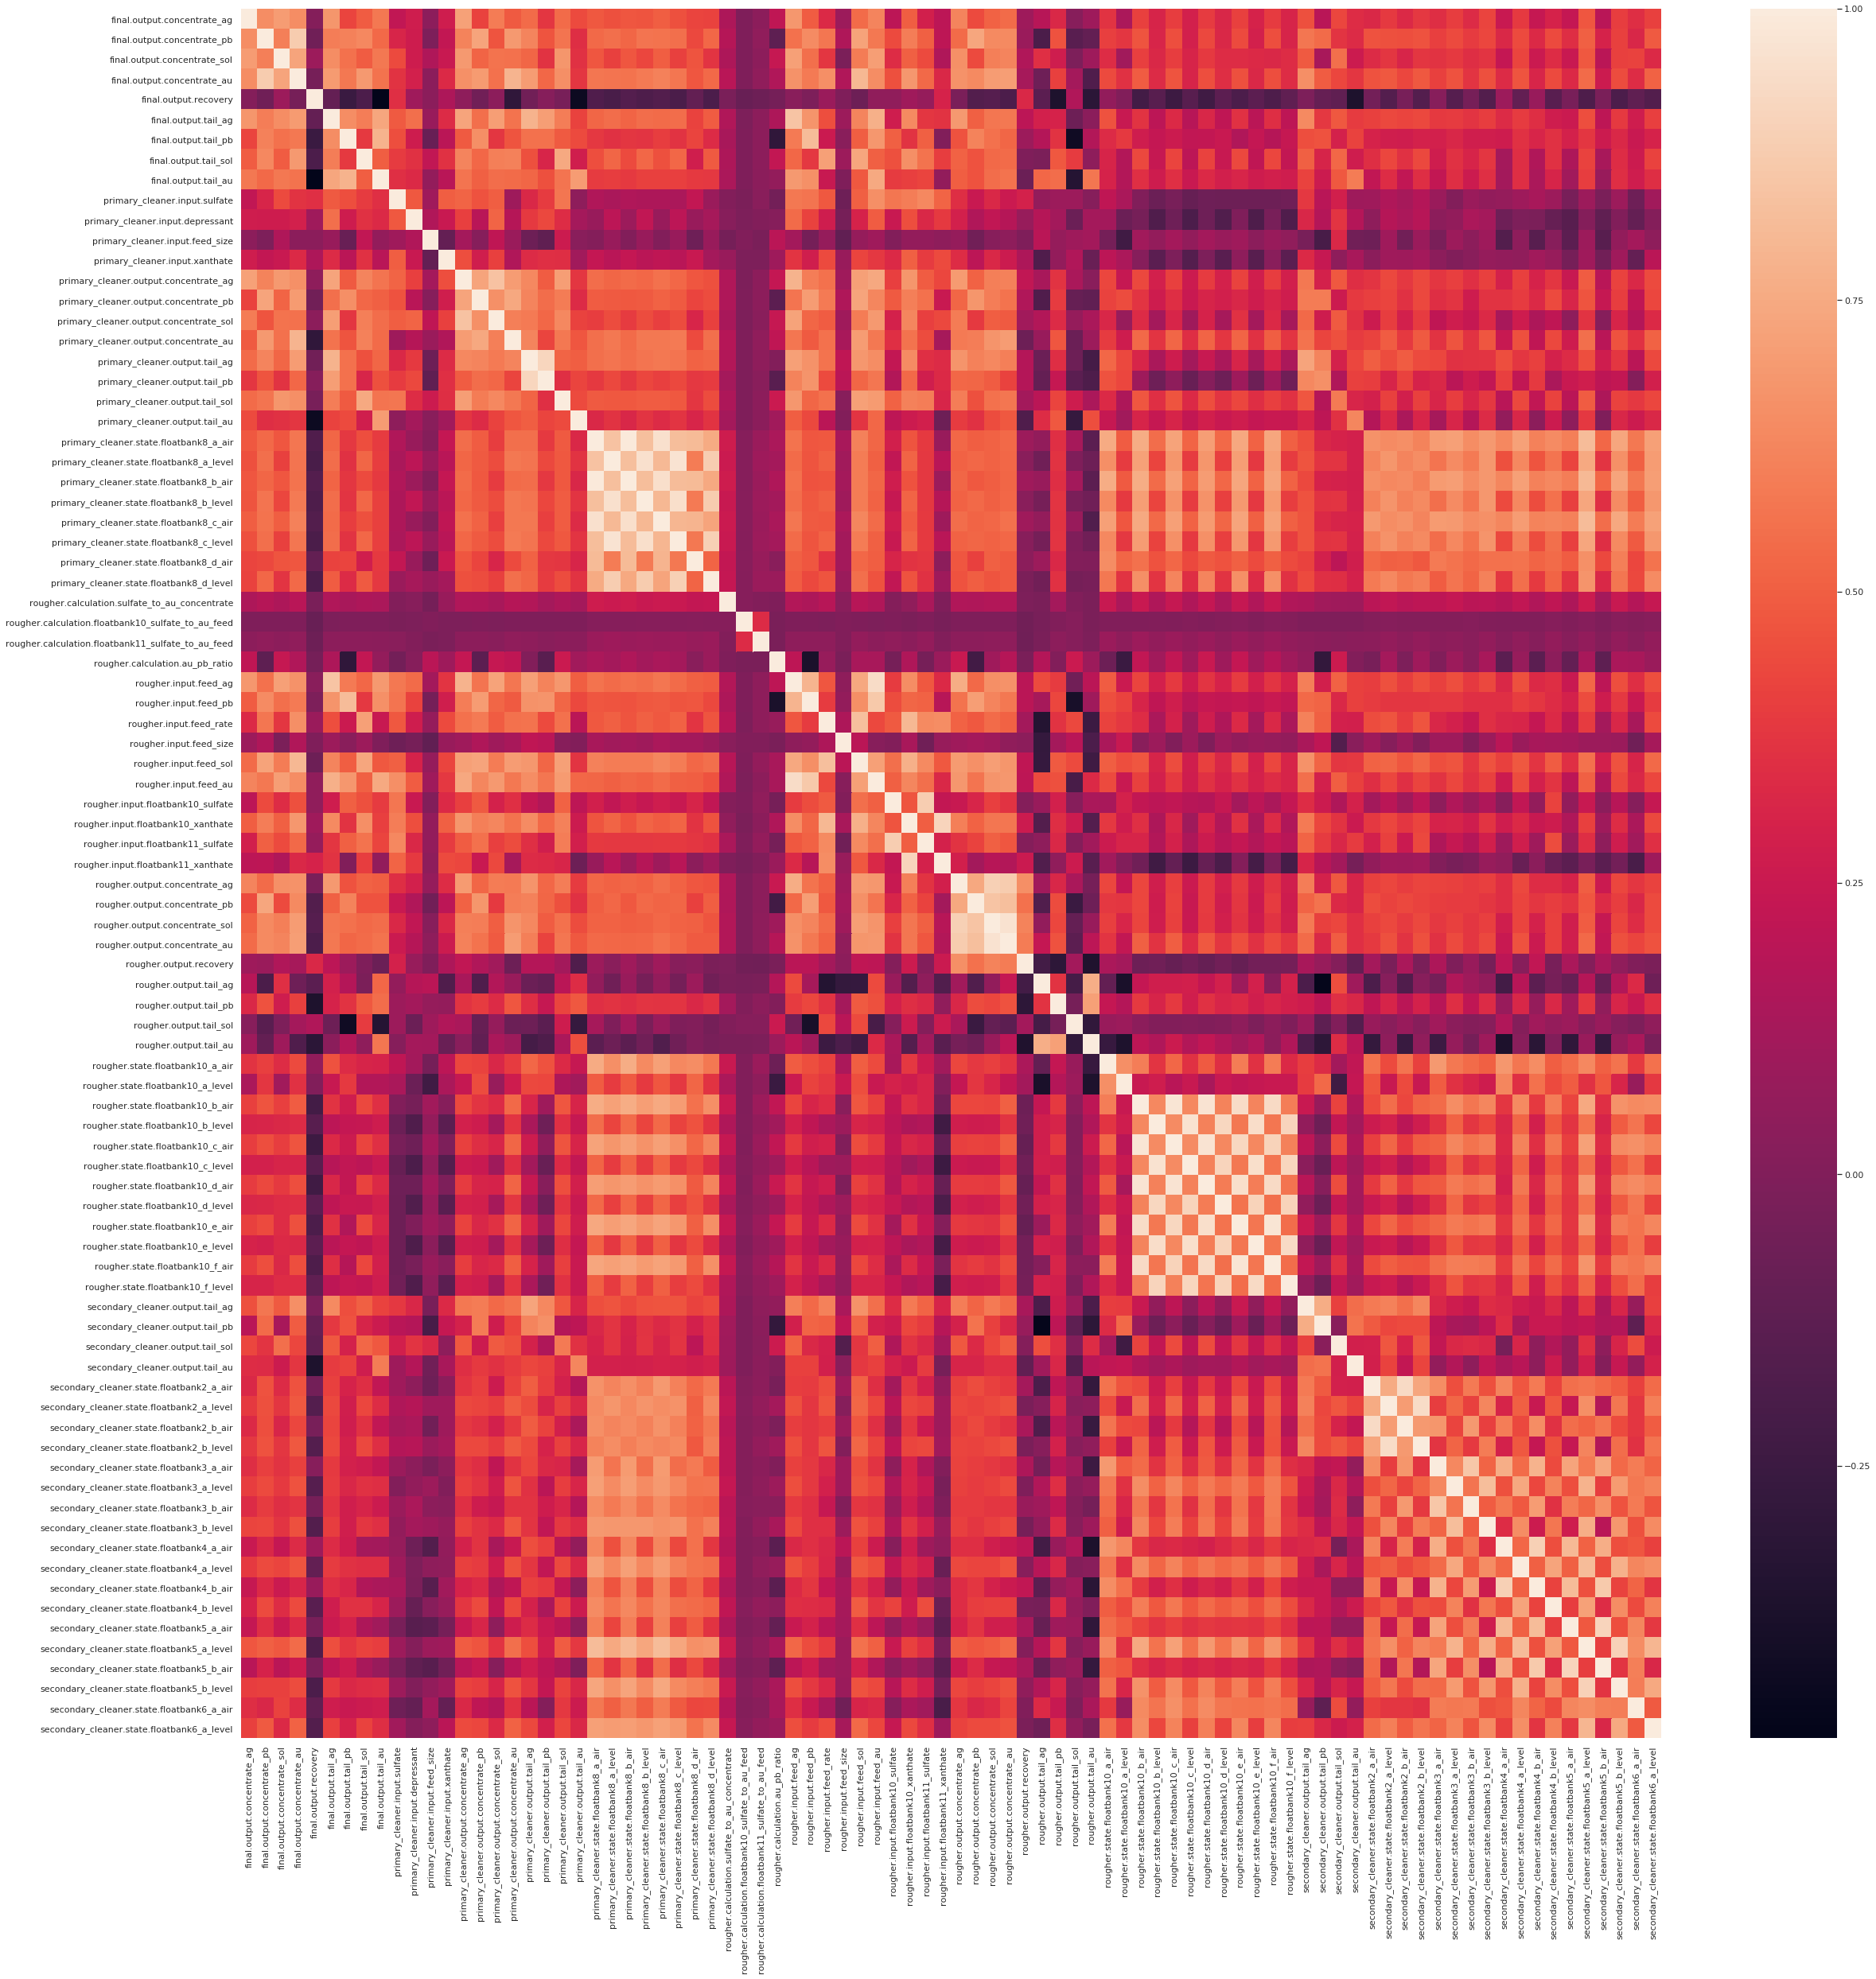

'----------------------------------------------------------------------------------------------------'

In [4]:
for df in [gold_recovery_train, gold_recovery_test, gold_recovery_full]:
    review(df)

## Проверка расчетов обогащения

In [5]:
def recovery(df, C, F, T): # расcчитывает эффективность обогащения
    C = df[C] # доля золота в концентрате после флотации
    F = df[F] # доля золота в сырье до флотации
    T = df[T] #  доля золота в отвальных хвостах после флотации 
    
    return (C * (F - T)) / (F * (C - T)) * 100

In [6]:
recovery_check = recovery(gold_recovery_train,
                                'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au')

In [7]:
'MAE: {}'.format((gold_recovery_train['rougher.output.recovery'] - recovery_check).abs().mean())

'MAE: 9.444891926100695e-15'

Средняя абсолютная ошибка очень маленькая, можно считать что данные recovery в таблице верный.

## Анализ признаков не доступных в тестовой выборке

In [8]:
set(gold_recovery_train.columns) - set(gold_recovery_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке нам не доступны:
- расчетные характеристики этапа флотации
- параметры выходных продуктов со всех этапов,
    в том числе целевых признаков 
    1. эффективность обогащения чернового концентрата rougher.output.recovery;
    2. эффективность обогащения финального концентрата final.output.recovery.

Как говорилось в условиях задачи, "некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже".

## Предобработка данных

In [9]:
def preprocessing(df):
    before = df.shape[0]
    df = df.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])
    df = df.fillna(method='ffill')
    after = df.shape[0]
    display('удалено {:.2%} строк'.format((before-after)/before))
    return df

In [10]:
gold_recovery_train = preprocessing(gold_recovery_train)

'удалено 16.08% строк'

# Анализ данных

## Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

In [11]:
def concentration(df, col1, col2, col3,col4):
    metals = ['au', 'ag', 'pb']
    names = {
    'au': 'золота',
    'ag': 'серебра',
    'pb': 'свинца'
    }
    for metal in metals:
        plt.figure(figsize=(16,10), dpi= 80)
        sns.kdeplot(df[col1 + metal], shade=True, color="g", label="начальная", alpha=.7)
        sns.kdeplot(df[col2 + metal], shade=True, color="deeppink", label="после флотации", alpha=.7)
        sns.kdeplot(df[col3 + metal], shade=True, color="dodgerblue", label="после первичной отчистки", alpha=.7)
        sns.kdeplot(df[col4 + metal], shade=True, color="orange", label="финальная", alpha=.7)

        plt.title('Концентрация ' + names[metal] + ' на этапах отчистки', fontsize=22)
        plt.legend()
        plt.show()

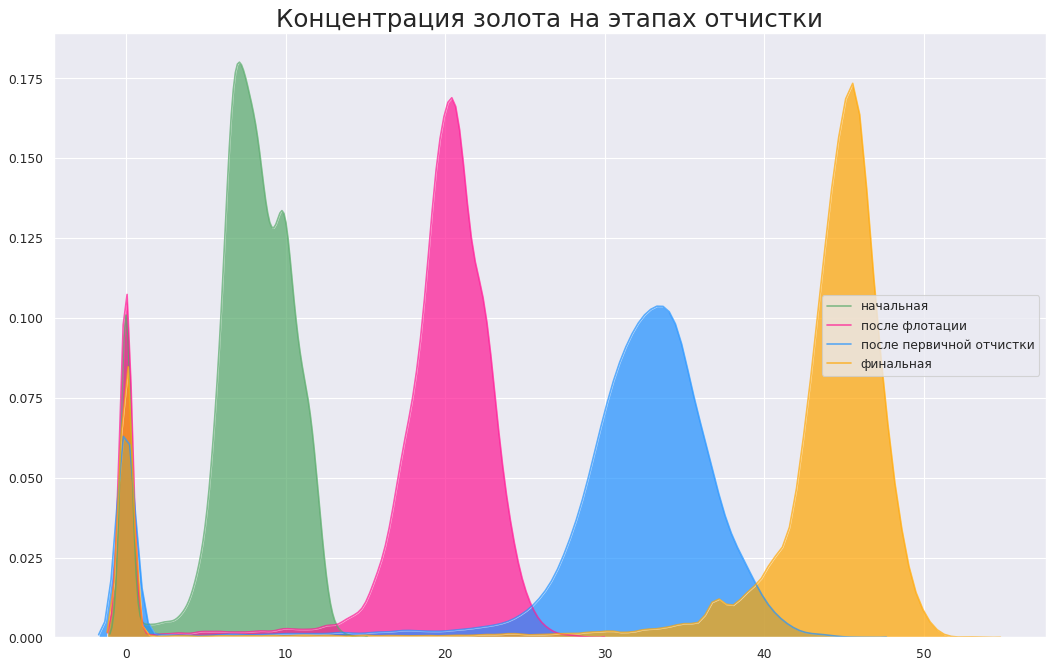

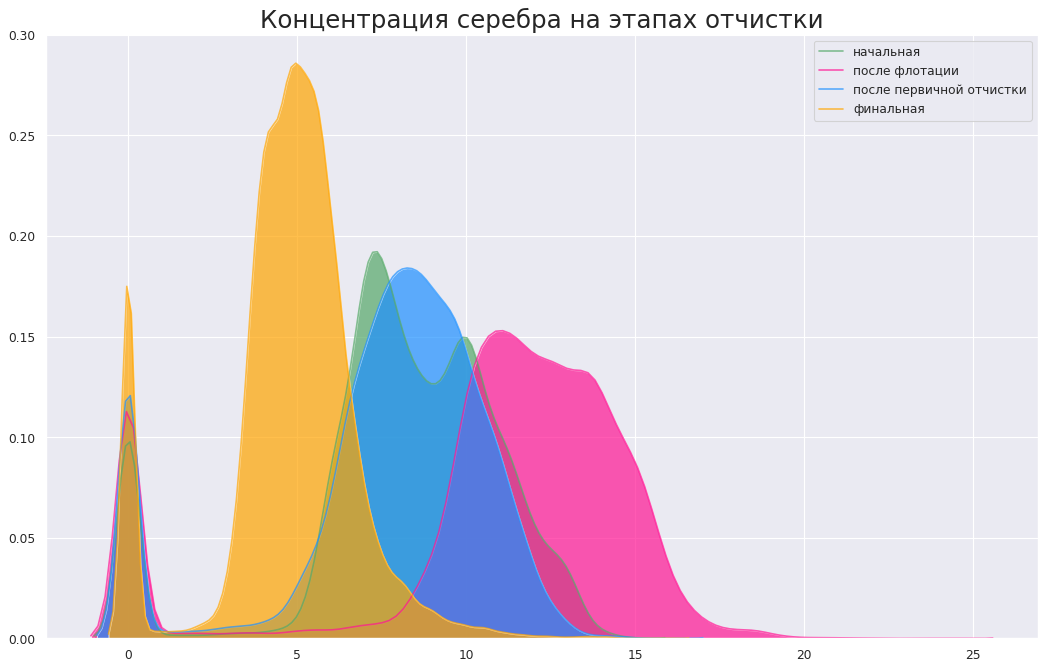

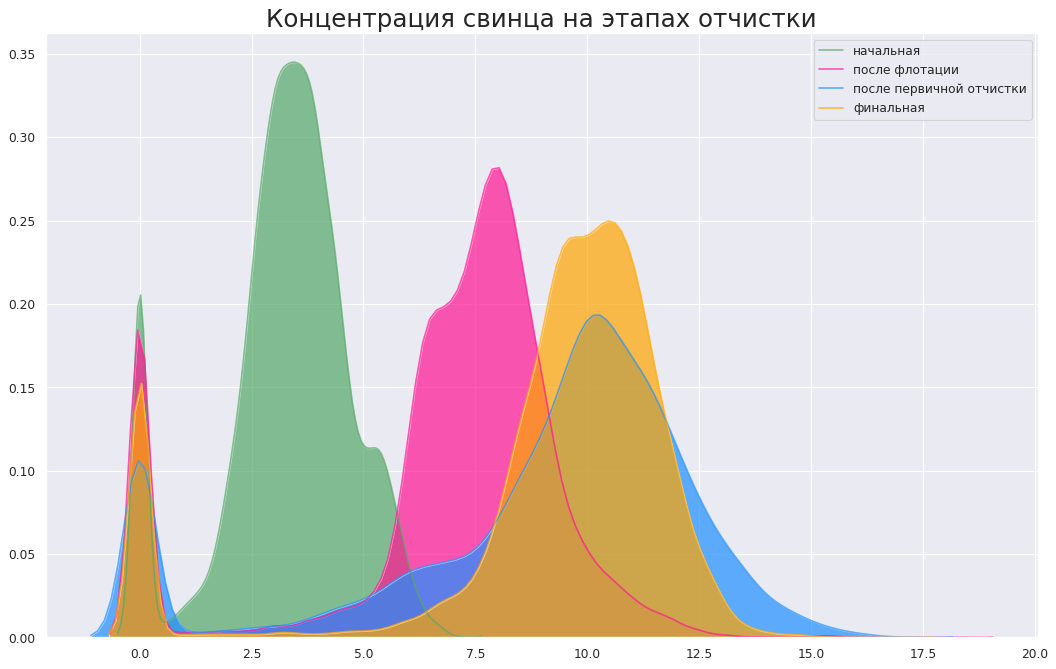

In [12]:
concentration(gold_recovery_full, 'rougher.input.feed_', 'rougher.output.concentrate_',
              'primary_cleaner.output.concentrate_', 'final.output.concentrate_')

Мы видим что после флотации повышается концентрация всех металлов. На этапе первичной фильтрации повышается концентарация тяжелых металлов (золота и свинца). На финальной отчистке мы видим, как золото отделяется от свинца.

## Сравним распределения размеров гранул сырья на обучающей и тестовой выборках

In [13]:
def size(col1, col2):
    plt.figure(figsize=(10,8), dpi= 100)
    sns.distplot(col1, color="dodgerblue", label="Train", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
    sns.distplot(col2, color="orange", label="Test", hist_kws={'alpha':.4}, kde_kws={'linewidth':3})
    plt.ylim(0, 0.055)

    plt.title('Размеры гранул сырья', fontsize=22)
    plt.legend()
    plt.show()

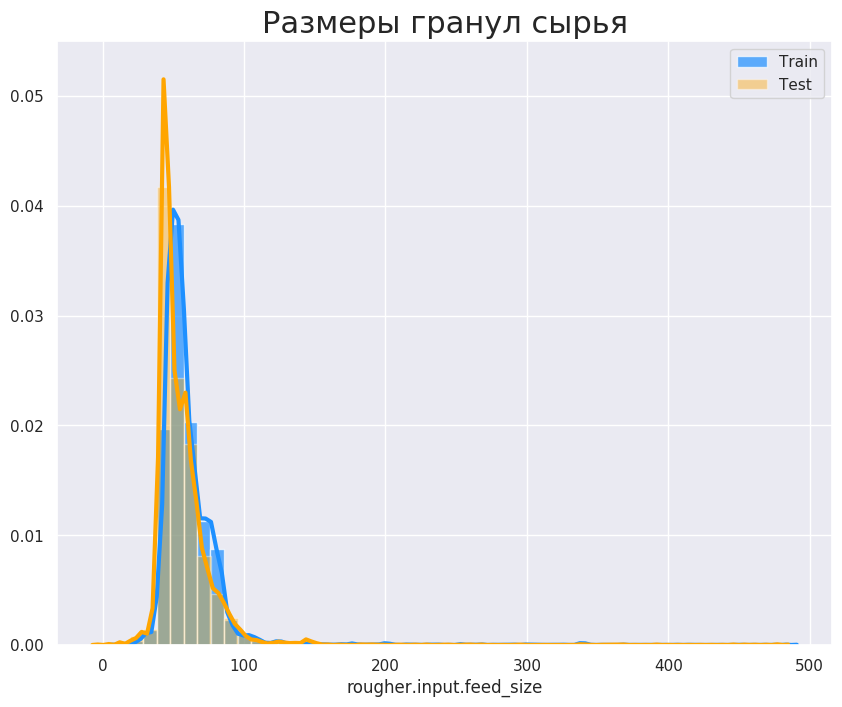

In [14]:
size(gold_recovery_train['rougher.input.feed_size'],
     gold_recovery_test['rougher.input.feed_size'].dropna())

В обоих случаях мы видим гаусеальное распределение с небольшим положительным смещением.

##  Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [15]:
def all_metal_concentration(df): # добавляет в таблицу сумму металлов, и рисует график
    df['rougher_input_feed_all_metal'] = (df['rougher.input.feed_au'] + 
                                 df['rougher.input.feed_ag'] + 
                                 df['rougher.input.feed_pb'])

    df['rougher_output_concentrate_all_metal'] = (df['rougher.output.concentrate_au'] + 
                                 df['rougher.output.concentrate_ag'] + 
                                 df['rougher.output.concentrate_pb'])

    df['primary_output_concentrate_all_metal'] = (df['primary_cleaner.output.concentrate_au'] + 
                                 df['primary_cleaner.output.concentrate_ag'] + 
                                 df['primary_cleaner.output.concentrate_pb'])


    df['final_output_concentrate_all_metal'] = (df['final.output.concentrate_au'] + 
                                 df['final.output.concentrate_ag'] + 
                                 df['final.output.concentrate_pb'])

    return df

In [16]:
def vizualization(df): # рисует график
    plt.figure(figsize=(16,10), dpi= 80)
    sns.kdeplot(df['rougher_input_feed_all_metal'], shade=True, color="g", label="начальная", alpha=.7)
    sns.kdeplot(df['rougher_output_concentrate_all_metal'], shade=True, color="deeppink", label="после флотации", alpha=.7)
    sns.kdeplot(df['primary_output_concentrate_all_metal'], shade=True, color="dodgerblue", label="после первичной отчистки", alpha=.7)
    sns.kdeplot(df['final_output_concentrate_all_metal'], shade=True, color="orange", label="финальная", alpha=.7)

    plt.title('Концентрация всех металлов, на этапах отчистки', fontsize=22)
    plt.legend()
    plt.show()

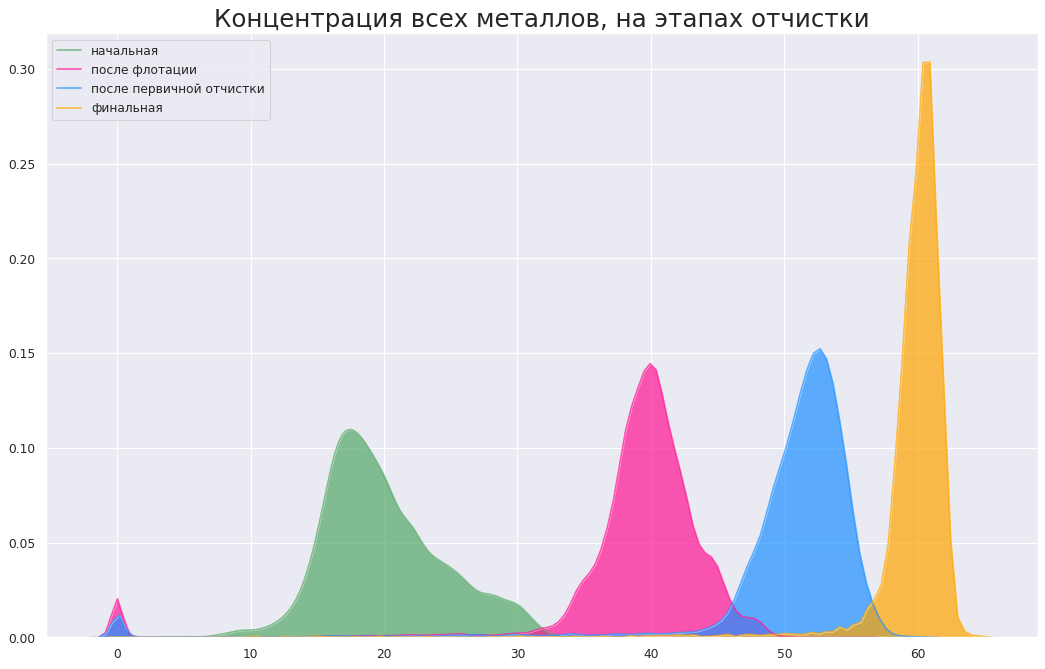

In [17]:
gold_recovery_train = all_metal_concentration(gold_recovery_train)
vizualization(gold_recovery_train)

Видим выбросы на всех этапах отчистки

In [18]:
def cleaning(df):
    before = df.shape[0]
    df = df.query('1 < rougher_input_feed_all_metal')
    df = df.query('1 < rougher_output_concentrate_all_metal')
    df = df.query('1 < primary_output_concentrate_all_metal')
    df = df.query('1 < final_output_concentrate_all_metal')
    after = df.shape[0]
    display('удалено {:.2%} строк'.format((before-after)/before))
    # борьба с выбросами дала хороший результат на модели
    rougher_input_feed_all_metal_low = df['rougher_input_feed_all_metal'].quantile(.025)
    rougher_input_feed_all_metal_up = df['rougher_input_feed_all_metal'].quantile(.975)
    rougher_output_concentrate_all_metal_low = df['rougher_output_concentrate_all_metal'].quantile(.025)
    rougher_output_concentrate_all_metal_up = df['rougher_output_concentrate_all_metal'].quantile(.975)    
    primary_output_concentrate_all_metal_low = df['primary_output_concentrate_all_metal'].quantile(.025)
    primary_output_concentrate_all_metal_up = df['primary_output_concentrate_all_metal'].quantile(.975)    
    final_output_concentrate_all_metal_low = df['final_output_concentrate_all_metal'].quantile(.025)
    final_output_concentrate_all_metal_up = df['final_output_concentrate_all_metal'].quantile(.975)
    
    df = df.query('@rougher_input_feed_all_metal_low < rougher_input_feed_all_metal < @rougher_input_feed_all_metal_up')
    df = df.query('@rougher_output_concentrate_all_metal_low < rougher_output_concentrate_all_metal < @rougher_output_concentrate_all_metal_up')
    df = df.query('@primary_output_concentrate_all_metal_low < rougher_output_concentrate_all_metal < @primary_output_concentrate_all_metal_up')
    df = df.query('@final_output_concentrate_all_metal_low < final_output_concentrate_all_metal < @final_output_concentrate_all_metal_up')
    
    return df

'удалено 3.89% строк'

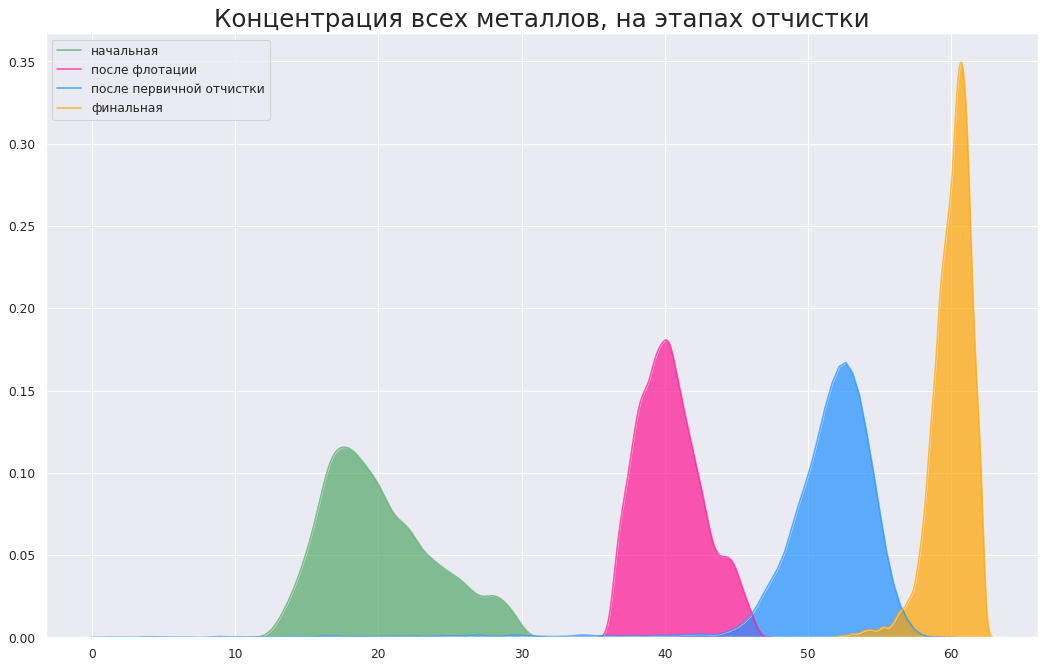

In [19]:
gold_recovery_train = cleaning(gold_recovery_train)
vizualization(gold_recovery_train)

# Модель

## Напишим функцию для вычисления итоговой sMAPE

In [20]:
def smape(y, y_pred): # считаем SMAPE
    smape = 1 / len(y) * (((abs(y_pred - y)) / ((abs(y) + abs(y_pred)) / 2)).sum()) * 100
    return smape

In [21]:
def final_smape(y, y_pred): # считаем final SMAPE
    smape_rougher = smape(y['rougher.output.recovery'], y_pred[:,0])
    smape_final = smape(y['final.output.recovery'], y_pred[:,1])

    final_smape = (smape_rougher * 0.25) + (smape_final * 0.75)
                                            
    return final_smape

In [22]:
scorer = make_scorer(final_smape, greater_is_better=False) # добавляем кастомный оценщик

## Выберем модель

In [23]:
def preprocessing_test(df):
    before = df.shape[0]
    df = df.merge(gold_recovery_full[['rougher.output.recovery', 'final.output.recovery']],
                  how = 'left', on='date') # добавляем целевые признаки
    # удаляем строки с пропусками в целевом признаке, заменяем остальные пропуски соседними значениями
    preprocessing(df) 
     # добавляем сумму металов на входе( оказалась не плохой фитчей)
    df['rougher_input_feed_all_metal'] = (df['rougher.input.feed_au'] + 
                                 df['rougher.input.feed_ag'] + 
                                 df['rougher.input.feed_pb'])
    # удаляем значения около 0, на графике мы видели что там выбросы
    df = df.query('1 < rougher_input_feed_all_metal')
    # убираем выбросы
    rougher_input_feed_all_metal_low = df['rougher_input_feed_all_metal'].quantile(.025)
    rougher_input_feed_all_metal_up = df['rougher_input_feed_all_metal'].quantile(.975)
    df = df.query('@rougher_input_feed_all_metal_low < rougher_input_feed_all_metal < @rougher_input_feed_all_metal_up')
    
    
    after = df.shape[0]
    display('удалено {:.2%} строк'.format((before-after)/before))
    return df

In [24]:
gold_recovery_test = preprocessing_test(gold_recovery_test)

'удалено 9.67% строк'

'удалено 11.30% строк'

In [25]:
def columns_eqwalization(train, test): # удаляем из тренировочной выборки признаки отсутствующие в тестовой
    train = train[test.columns]
    return train

In [26]:
gold_recovery_train = columns_eqwalization(gold_recovery_train,gold_recovery_test)

In [27]:
def features_target_split(df,target_col): # отделяет целевой признак
    features = df.drop(columns=target_col)
    target = df[target_col]
    return features, target

In [28]:
features_train, target_train = features_target_split(gold_recovery_train,['rougher.output.recovery',
                                                                          'final.output.recovery'])

In [29]:
pipe = Pipeline([ 
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
scor=cross_val_score(pipe, features_train, target_train, cv=3, scoring=scorer)
print(abs(scor.mean()))

12.092689151746585


In [30]:
best_scor = 100
etr_model = ExtraTreesRegressor(random_state=42)

scor=cross_val_score(etr_model, features_train, target_train, cv=3, scoring=scorer)
scor = abs(scor.mean())

print(scor)

11.05401025717677


In [31]:
best_scor = 100
rfr_model = RandomForestRegressor(random_state=42)

scor=cross_val_score(rfr_model, features_train, target_train, cv=3, scoring=scorer)
scor = abs(scor.mean())

print(scor)

10.671743812862161


лучше всего среди не настроенных моделей себя показал "случайный леc"

In [32]:
# Фитчи упорядоченные от самых важных для модели RandomForestRegressor
importance_columns = ['rougher.input.feed_ag',
       'secondary_cleaner.state.floatbank4_a_air',
       'primary_cleaner.input.sulfate', 'rougher.input.feed_au',
       'secondary_cleaner.state.floatbank5_b_air',
       'rougher.state.floatbank10_b_air',
       'secondary_cleaner.state.floatbank4_b_air',
       'rougher.input.floatbank10_xanthate',
       'secondary_cleaner.state.floatbank2_a_air',
       'primary_cleaner.input.depressant',
       'rougher.state.floatbank10_d_air',
       'rougher.input.floatbank11_xanthate',
       'rougher_input_feed_all_metal', 'primary_cleaner.input.xanthate',
       'rougher.input.feed_sol', 'rougher.input.floatbank11_sulfate',
       'rougher.input.feed_size', 'primary_cleaner.input.feed_size',
       'rougher.input.feed_pb', 'rougher.input.floatbank10_sulfate',
       'rougher.state.floatbank10_f_air',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank6_a_air',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_b_air',
       'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_a_level', 'rougher.input.feed_rate',
       'secondary_cleaner.state.floatbank5_a_air',
       'primary_cleaner.state.floatbank8_a_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'primary_cleaner.state.floatbank8_d_level',
       'primary_cleaner.state.floatbank8_c_level',
       'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_e_air',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_b_level',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank5_b_level',
       'secondary_cleaner.state.floatbank2_b_level',
       'rougher.state.floatbank10_f_level',
       'rougher.state.floatbank10_b_level',
       'primary_cleaner.state.floatbank8_a_level',
       'secondary_cleaner.state.floatbank6_a_level',
       'rougher.state.floatbank10_c_level',
       'secondary_cleaner.state.floatbank4_b_level',
       'rougher.state.floatbank10_e_level',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank4_a_level',
       'rougher.state.floatbank10_d_level']

In [33]:
def importanced(df,cols): #оставляем только важные признаки
    df = df[cols]
    return df

In [34]:
features_train = importanced(features_train,
                             importance_columns[:16]) # признаки подобраны эмпирическим путем

In [35]:
best_scor = 100


for est in trange(30,31,1): # сократил количество итераций чтобы код работал быстрее
    for depth in range(7,8):
        rfr_model = RandomForestRegressor(random_state=42, max_depth=depth, n_estimators=est)

        scor=cross_val_score(rfr_model, features_train, target_train, cv=7, scoring=scorer)
        scor = abs(scor.mean())
        if scor < best_scor:
            best_scor = scor
            best_depth = depth
            best_estimators = est
print(f' sMAPE: {best_scor}, глубина: {best_depth}, количество деревьев: {best_estimators}')


 sMAPE: 7.784774986969042, глубина: 7, количество деревьев: 30


посмотрим на важность признаков

In [36]:
rfr_model.fit(features_train, target_train)
features_train_importance = pd.DataFrame({'name' : features_train.columns,
                                          'importance' : rfr_model.feature_importances_})
features_train_importance = features_train_importance.sort_values('importance', ascending=False)
    #importance_columns = np.array(features_train_importance['name'])
features_train_importance    

,name,importance
0,rougher.input.feed_ag,0.28
1,secondary_cleaner.state.floatbank4_a_air,0.14
2,primary_cleaner.input.sulfate,0.11
8,secondary_cleaner.state.floatbank2_a_air,0.08
5,rougher.state.floatbank10_b_air,0.07
4,secondary_cleaner.state.floatbank5_b_air,0.06
10,rougher.state.floatbank10_d_air,0.06
7,rougher.input.floatbank10_xanthate,0.04
6,secondary_cleaner.state.floatbank4_b_air,0.03
15,rougher.input.floatbank11_sulfate,0.03


## Тестирование модели

In [37]:
# отделяем целевые признаки
features_test, target_test = features_target_split(gold_recovery_train,['rougher.output.recovery',
                                                                          'final.output.recovery'])

In [38]:
features_test = importanced(features_test,
                             importance_columns[:16]) #оставляем важные признаки

In [39]:
final_model = RandomForestRegressor(random_state=42, max_depth=7, n_estimators=30)
final_model.fit(features_train, target_train)
smape_model = scorer(final_model, features_test, target_test)
print(f'sMAPE: {abs(smape_model)}')

sMAPE: 5.232050786676371


проверим модель на адекватность

In [40]:
dummy_model = DummyRegressor(strategy='median')
dummy_model.fit(features_train, target_train)
smape_model = scorer(dummy_model, features_test, target_test)
print(f'sMAPE: {abs(smape_model)}')

sMAPE: 8.833820853336626


Наша модель показывает лучший результат в сравнение с глупой моделью

# Вывод:

- Наша модель ошибается всего на 5.23 % в предсказании восстановления золота из руды. 
- Из обучающей выборки пришлось удалить 16 % строк из-за отсутствия ключевых признаков. А учитывая что модель на тестовой выборке показала лучший результат, чем на кросс валидации, за счет увелечения обучающих данных. Возможно у нашей модели есть потенциал роста точности, за счет увеличения обучающих данных.
- Есть большая вероятность что если мы получим данные после этапа флотации, нам удастся значительно улучшить модель.
